In [1]:
import argparse
import os
import random
import torch
import yaml
from torch.utils.data import DataLoader
from train_model.dataset_utils import prepare_test_data_set
import numpy as np
from os import listdir
from dataset_utils import text_processing
from train_model.helper import run_model, build_model
from IPython.display import Image, display, clear_output

# Get test images
# wget http://images.cocodataset.org/zips/test2015.zip, unzip and update path to image directory
im_dir = '/private/home/nvivek/vqa_2.0/test2015'
# Get the models
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/pretrained_models/most_data_models.tar.gz and 
# move the best_model.pth from the uncompressed file to the folder best_model
# Get features
# mkdir data
# cd data
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vqa2.0_glove.6B.300d.txt.npy
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/answers_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/imdb.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/rcnn_10_100.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vqa2.0_glove.6B.300d.txt.npy
# tar -xf rcnn_10_100.tar.gz
# tar -xf imdb.tar.gz

config_file = 'best_model/config.yaml'
model_file = 'best_model/best_model.pth'


def get_image():
    im_files = [f for f in os.listdir(im_dir)]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    print(im_path)
    clear_output()
    display(Image(filename=im_path))
    return im_file

def get_imdb(im_file, question_str):
    imdb = []
    imdb.append({'create_time': '2018-03-29 16:39', 'dataset_name': 'vqa', 'version': 1, 'has_answer': False, 'has_gt_layout': False})
    iminfo = {}
    iminfo['image_name'] = im_file.replace('.jpg', '')
    iminfo['img_id'] = int(iminfo['image_name'].split('_')[-1])
    iminfo['question_id'] = 0
    iminfo['feature_path'] = iminfo['image_name'] + '.npy'
    iminfo['question_str'] = question_str
    iminfo['question_tokens'] = text_processing.tokenize(iminfo['question_str'])
    imdb.append(iminfo)
    return imdb

def print_result(question_ids, soft_max_result, ans_dic):
    predicted_answers = np.argmax(soft_max_result, axis=1)
    for idx, pred_idx in enumerate(predicted_answers):
        question_id = question_ids[idx]
        pred_ans = ans_dic.idx2word(pred_idx)
        print(pred_ans)

def demo():

    with open(config_file, 'r') as f:
        config = yaml.load(f)

    data_set_test = prepare_test_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)

    myModel = build_model(config, data_set_test)
    myModel.load_state_dict(torch.load(model_file)['state_dict'])

    print('VQA Demo')
    print('Say next to go to next image')
    print('Say stop to stop demo')
    im_file = get_image()
    while(True):
        print("What question would you like to ask?")
        question_str = input()
        if question_str.lower() == 'next':
            im_file = get_image()
            continue
        if question_str.lower() == 'stop':
            print('Bye')
            break
        data_set_test.datasets[0].imdb = get_imdb(im_file, question_str)
        data_reader_test = DataLoader(data_set_test, shuffle=False, batch_size=1)
        ans_dic = data_set_test.answer_dict

        question_ids, soft_max_result = run_model(myModel, data_reader_test, ans_dic.UNK_idx)
        print_result(question_ids, soft_max_result, ans_dic)

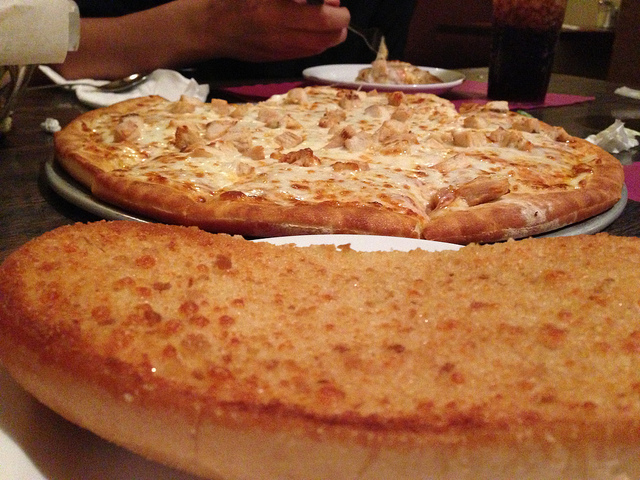

What question would you like to ask?
what is in the image?
pizza
What question would you like to ask?
what type of pizza?
cheese
What question would you like to ask?
what color is the pizza?
yellow
What question would you like to ask?
is the pizza hot?
yes
What question would you like to ask?
is  the pizza fresh?
yes
What question would you like to ask?
clear
yes
What question would you like to ask?
bye
no
What question would you like to ask?
stop
Bye


In [2]:
demo()